# ImagePDF - wmin (Full Covmat + Mini Batch Training)

In [1]:
import itertools

import numpy as np

import jax.numpy as jnp
import jax

from jax.example_libraries import optimizers

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.commondataparser import load_commondata

from reportengine import collect

import pandas as pd
from validphys.core import DataGroupSpec

from validphys.pdfbases import evolution
from validphys import convolution
from validphys import covmats
from validphys.loader import Loader

import jax.scipy.linalg as jla



In [2]:
inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": {"from_": "fit"},
    "use_cuts": "internal",
    "theoryid": 400
}

In [3]:
data = API.data(**inp)

In [4]:
# store grids with shape (50,) only
xx = []

excluded = set()
included = set()

for ds in data.datasets:

    for fk in ds.fkspecs:

        xgrid = load_fktable(fk).xgrid
        
        if xgrid.shape != (50,):
            print("Excluding", ds)
            excluded.add(ds)
            continue
        else:
            xx.append(xgrid)
            included.add(ds)
included = list(included)

Excluding ATLAS_1JET_8TEV_R06_DEC
Excluding ATLAS_2JET_7TEV_R06
Excluding CMS_2JET_7TEV
Excluding CMS_1JET_8TEV


In [5]:
class FilteredDataGroupSpec(DataGroupSpec):
        pass

filtered_data = FilteredDataGroupSpec(name = "data", datasets = tuple(included), dsinputs = included)

In [6]:
# test the all the x grids are the same
arr = np.array(xx)
arr.std(axis=0).max()

1.3322676295501878e-15

In [7]:
# list of datasetspecs
datasets = list(filtered_data.dsinputs)

In [8]:
# TODO: Is this needed? -> probably no need to jit compile
# jit: just-in-time (JIT) compilation decorator
# compile functions
OP = {key: jax.jit(val) for key,val in convolution.OP.items()}

In [9]:
rng = jax.random.PRNGKey(0xDEADBEEF)

In [10]:
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")

# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xx[0], [1.65]).squeeze(-1)

# initial weights for weight minimization
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)

LHAPDF 6.4.0 loading all 101 PDFs in set 210713-n3fit-001
210713-n3fit-001, version 1; 101 PDF members


In [11]:
pdf

PDF(name='210713-n3fit-001')

In [12]:
evolution.grid_values

<bound method Basis.grid_values of <validphys.pdfbases.LinearBasis object at 0x185cf1490>>

## Prediction Functions

In [13]:
def make_dis_prediction(fk):
    """
    TODO
    
    Parameters
    ----------
    fk : 
    
    Returns
    -------
    
    
    """
    indices = fk.luminosity_mapping
    fk_arr = jnp.array(fk.get_np_fktable())
    
    @jax.jit
    def dis_prediction(pdf):
        """
        Compute theory prediction as
        
        T_i = FK_{i,a,x} f_{a,x}
        
        summing over repeated indices
        
        Parameters
        ----------
        pdf : 
        
        """
        return jnp.einsum("ijk, jk ->i", fk_arr, pdf[indices, :])
    return dis_prediction
    
    
def make_had_prediction(fk):
    indices = fk.luminosity_mapping
    first_indices = indices[0::2]
    second_indices = indices[1::2]
    fk_arr = jnp.array(fk.get_np_fktable())
    @jax.jit
    def had_prediction(pdf):
        return jnp.einsum("ijkl,jk,jl->i", fk_arr, pdf[first_indices,:], pdf[second_indices,:])
    return had_prediction


def make_pred_dataset(dataset):
    """
    """
    
    pred_funcs = []
    
    # why does each dataset have several fkspecs?
    # e.g. compound has two fkspec?
    
    for fkspec in dataset.fkspecs:
        fk = load_fktable(fkspec).with_cuts(dataset.cuts)
        if fk.hadronic:
            pred = make_had_prediction(fk)
        else:
            pred = make_dis_prediction(fk)
        pred_funcs.append(pred)
    @jax.jit
    def prediction(pdf):
        return OP[dataset.op](*[f(pdf) for f in pred_funcs])
    
    return prediction

def make_pred_data(data):
    """
    TODO
    same as make_pred_datasets but for datagroupspec
    
    returns jnp.array
    
    """
    predictions = []
    for ds in data.datasets:
        predictions.append(make_pred_dataset(ds))

    def eval_preds(pdf):
        return jnp.array(list(itertools.chain(*[f(pdf) for f in predictions])))

    return eval_preds

In [14]:
make_pred_dataset(datasets[41])(INPUT_GRID[1]) - jnp.array(datasets[41].load_commondata().central_values)

DeviceArray([-3.28403320e+01, -2.40738525e+01, -1.76942749e+01,
             -7.45385742e+00, -9.35925293e+00, -5.25611877e+00,
             -2.24153519e+00, -1.28259087e+00, -3.58649292e+01,
             -3.03795166e+01, -1.42949524e+01, -8.84130859e+00,
             -6.74705505e+00, -6.26600647e+00, -2.17771912e+00,
             -1.17774582e+00, -3.92044678e+01, -2.89486084e+01,
             -1.64168091e+01, -1.08521576e+01, -6.61549377e+00,
             -4.88388062e+00, -2.61560440e+00, -7.72499084e-01,
             -3.57440796e+01, -2.13838806e+01, -1.40100098e+01,
             -1.08454132e+01, -6.47629547e+00, -5.13329315e+00,
             -1.32273102e+00, -6.72040939e-01, -3.43396301e+01,
             -1.83039551e+01, -1.41732025e+01, -6.20283508e+00,
             -4.69388580e+00, -2.72694016e+00, -1.47815323e+00,
             -2.84096718e-01, -9.61286926e+00, -6.51184082e+00,
             -2.86858368e+00, -2.67317581e+00, -6.45584106e-01,
             -1.43944931e+00, -3.2298278

In [15]:
make_pred_dataset(datasets[42])#(INPUT_GRID[0])

<CompiledFunction of <function make_pred_dataset.<locals>.prediction at 0x186f150d0>>

In [16]:
m_p_d = make_pred_data(filtered_data)

In [17]:
INPUT_GRID[0].shape

(14, 50)

In [18]:
m_p_d(INPUT_GRID[0])

DeviceArray([6.4446531e-02, 2.2849444e-01, 3.1073904e-01, ...,
             1.6747969e+02, 1.6702826e+00, 6.1947426e+01], dtype=float32)

## Loss functions

In [19]:
def make_chi2(ds):
    """
    
    """
    cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

    central_value = jnp.array(cd.central_values)

    covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)

    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

    pred = make_pred(ds)
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_value
        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


def make_chi2_data(data):
    """
    
    """

    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_values

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2

def make_chi2_data_mini_batch(data):
    """
    
    """

    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf,batch_idx):
        """
        TODO
        """
        diff = pred(pdf)[batch_idx] - central_values[batch_idx]

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat[batch_idx][:,batch_idx], diff[batch_idx], lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


chi2_contribs_data = make_chi2_data(filtered_data)
chi2_contribs_data_mini_batch = make_chi2_data_mini_batch(filtered_data)

@jax.jit
def loss_data(weights):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data(pdf)



In [20]:
print(m_p_d(INPUT_GRID[0]).shape)

Ndat = m_p_d(INPUT_GRID[0]).shape[0]


(4116,)


In [21]:
m_p_d(INPUT_GRID[0])

DeviceArray([6.4446531e-02, 2.2849444e-01, 3.1073904e-01, ...,
             1.6747969e+02, 1.6702826e+00, 6.1947426e+01], dtype=float32)

## mini batch gradient descendt

In [22]:
@jax.jit
def loss_data_batch(weights,batch_idx):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data_mini_batch(pdf,batch_idx)

### mini batches generator

In [ ]:
def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = [index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

In [23]:
import numpy as np

# is bugged as it does not always yield batches of the same shape

def random_subset(Ndat, batch_size):
    """
    Yield a generator for random mini-batches of indices of size `batch_size` from an array of size `Ndat`
    """
    while True:
        # generate a random permutation of indices
        perm = np.random.permutation(Ndat)
        
        # create mini-batches of size `batch_size`
        for i in range(0, Ndat, batch_size):
            yield perm[i:i+batch_size]

# Example
# set the parameters
batch_size = 10

# initialize the random mini-batch generator
batch_index = random_subset(Ndat, batch_size)

# get the first mini-batch
mini_batch1 = next(batch_index)
print(mini_batch1)

# get the second mini-batch
mini_batch2 = next(batch_index)
print(mini_batch2)

[3133 3925 3134 3180 1538 2070  440 1880 1978 3570]
[3591 3882 3909 2026 2398  317  752 3787   39 3899]


In [68]:
import numpy as np

def random_neighbouring_subset(shape, batch_size):
    # calculate the maximum start index that allows for a full batch
    max_start = shape - batch_size
    
    # generate a random start index
    start_idx = np.random.randint(0, max_start + 1)
    
    # return a generator that yields neighbouring subsets
    while True:
        yield np.arange(start_idx, start_idx + batch_size)
        start_idx = np.random.randint(0, max_start + 1)


gen = random_neighbouring_subset(Ndat,Ndat)
for i in range(10):
    print(next(gen))

[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]
[   0    1    2 ... 4113 4114 4115]


### Train model using jax optimizers example library

In [24]:
# compute grad on mini batch
grad = jax.grad(loss_data_batch)(weight_base,jnp.array([0,1,2,3]))

In [99]:
momentum_mass = 0.9

step_size = 1e-8

num_epochs = 500

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass = momentum_mass)
# opt_init, opt_update, get_params = optimizers.adagrad(step_size, momentum = momentum_mass)

In [100]:
@jax.jit
def update(step,opt_state,batch_idx):
    params  = get_params(opt_state)
    return opt_update(step, jax.grad(loss_data_batch)(params,batch_idx),opt_state)

In [104]:
opt_counter = itertools.count()
opt_state = opt_init(weight_base)

batch_size = 15
# batch_iterator = random_neighbouring_subset(Ndat, batch_size)
batch_iterator = random_subset(Ndat, batch_size)

for epoch in range(num_epochs):
    # get batch index from generator
    batch_idx = next(batch_iterator)
    
    print(f"Epoch {epoch}, loss {loss_data_batch(get_params(opt_state),batch_idx):.3f}, \
          len(batch_idx) = {len(batch_idx)}")
    
    opt_state = update(next(opt_counter), opt_state, batch_idx)
    
    

Epoch 0, loss 0.167,           len(batch_idx) = 15
Epoch 1, loss 9303.469,           len(batch_idx) = 15
Epoch 2, loss 5.101,           len(batch_idx) = 15
Epoch 3, loss 311.050,           len(batch_idx) = 15
Epoch 4, loss 0.013,           len(batch_idx) = 15
Epoch 5, loss 98.562,           len(batch_idx) = 15
Epoch 6, loss 193.649,           len(batch_idx) = 15
Epoch 7, loss 9786502.000,           len(batch_idx) = 15
Epoch 8, loss 570.612,           len(batch_idx) = 15
Epoch 9, loss 0.117,           len(batch_idx) = 15
Epoch 10, loss 17543474446336.000,           len(batch_idx) = 15
Epoch 11, loss 40.824,           len(batch_idx) = 15
Epoch 12, loss 271.475,           len(batch_idx) = 15
Epoch 13, loss 1901.234,           len(batch_idx) = 15
Epoch 14, loss 1.922,           len(batch_idx) = 15
Epoch 15, loss 63.084,           len(batch_idx) = 15
Epoch 16, loss 2.532,           len(batch_idx) = 15
Epoch 17, loss 1.538,           len(batch_idx) = 15
Epoch 18, loss 23976732672.000,       

Epoch 151, loss 473547.344,           len(batch_idx) = 15
Epoch 152, loss 605798.750,           len(batch_idx) = 15
Epoch 153, loss 9060364288.000,           len(batch_idx) = 15
Epoch 154, loss 1709307.000,           len(batch_idx) = 15
Epoch 155, loss 667378.125,           len(batch_idx) = 15
Epoch 156, loss 2601543.250,           len(batch_idx) = 15
Epoch 157, loss 18175746.000,           len(batch_idx) = 15
Epoch 158, loss 1725562.375,           len(batch_idx) = 15
Epoch 159, loss 228.103,           len(batch_idx) = 15
Epoch 160, loss 15818868736.000,           len(batch_idx) = 15
Epoch 161, loss 1531427.625,           len(batch_idx) = 15
Epoch 162, loss 74767.078,           len(batch_idx) = 15
Epoch 163, loss 386582.750,           len(batch_idx) = 15
Epoch 164, loss 6208.737,           len(batch_idx) = 15
Epoch 165, loss 1915464.625,           len(batch_idx) = 15
Epoch 166, loss 20.871,           len(batch_idx) = 15
Epoch 167, loss 733030.688,           len(batch_idx) = 15
Epoch 16

Epoch 290, loss 2307498.500,           len(batch_idx) = 15
Epoch 291, loss 60415586691035693056.000,           len(batch_idx) = 15
Epoch 292, loss 5379058.500,           len(batch_idx) = 15
Epoch 293, loss 10279405075038208.000,           len(batch_idx) = 15
Epoch 294, loss 3786067673088.000,           len(batch_idx) = 15
Epoch 295, loss 1249912311510990848.000,           len(batch_idx) = 15
Epoch 296, loss 79242856.000,           len(batch_idx) = 15
Epoch 297, loss 655328192.000,           len(batch_idx) = 15
Epoch 298, loss 321111904.000,           len(batch_idx) = 15
Epoch 299, loss 30229582.000,           len(batch_idx) = 15
Epoch 300, loss 83497.445,           len(batch_idx) = 15
Epoch 301, loss 35910896.000,           len(batch_idx) = 15
Epoch 302, loss 80537108480.000,           len(batch_idx) = 15
Epoch 303, loss 7342807.500,           len(batch_idx) = 15
Epoch 304, loss 12348725686960128.000,           len(batch_idx) = 15
Epoch 305, loss 1432793.375,           len(batch_idx) =

Epoch 425, loss 712472.812,           len(batch_idx) = 15
Epoch 426, loss 22871568434593792.000,           len(batch_idx) = 15
Epoch 427, loss 26103182.000,           len(batch_idx) = 15
Epoch 428, loss 3399145.750,           len(batch_idx) = 15
Epoch 429, loss 29868.701,           len(batch_idx) = 15
Epoch 430, loss 1593143.750,           len(batch_idx) = 15
Epoch 431, loss 528616.875,           len(batch_idx) = 15
Epoch 432, loss 23176458.000,           len(batch_idx) = 15
Epoch 433, loss 2058056.000,           len(batch_idx) = 15
Epoch 434, loss 3088140800.000,           len(batch_idx) = 15
Epoch 435, loss 2055402.625,           len(batch_idx) = 15
Epoch 436, loss 2542808.250,           len(batch_idx) = 15
Epoch 437, loss 591628.125,           len(batch_idx) = 15
Epoch 438, loss 1761979.125,           len(batch_idx) = 15
Epoch 439, loss 83148.281,           len(batch_idx) = 15
Epoch 440, loss 31252790.000,           len(batch_idx) = 15
Epoch 441, loss 125447.992,           len(batch

Epoch 578, loss nan,           len(batch_idx) = 15
Epoch 579, loss nan,           len(batch_idx) = 15
Epoch 580, loss nan,           len(batch_idx) = 15
Epoch 581, loss nan,           len(batch_idx) = 15
Epoch 582, loss nan,           len(batch_idx) = 15
Epoch 583, loss nan,           len(batch_idx) = 15
Epoch 584, loss nan,           len(batch_idx) = 15
Epoch 585, loss nan,           len(batch_idx) = 15
Epoch 586, loss nan,           len(batch_idx) = 15
Epoch 587, loss nan,           len(batch_idx) = 15
Epoch 588, loss nan,           len(batch_idx) = 15
Epoch 589, loss nan,           len(batch_idx) = 15
Epoch 590, loss nan,           len(batch_idx) = 15
Epoch 591, loss nan,           len(batch_idx) = 15
Epoch 592, loss nan,           len(batch_idx) = 15
Epoch 593, loss nan,           len(batch_idx) = 15
Epoch 594, loss nan,           len(batch_idx) = 15
Epoch 595, loss nan,           len(batch_idx) = 15
Epoch 596, loss nan,           len(batch_idx) = 15
Epoch 597, loss nan,           

Epoch 743, loss nan,           len(batch_idx) = 15
Epoch 744, loss nan,           len(batch_idx) = 15
Epoch 745, loss nan,           len(batch_idx) = 15
Epoch 746, loss nan,           len(batch_idx) = 15
Epoch 747, loss nan,           len(batch_idx) = 15
Epoch 748, loss nan,           len(batch_idx) = 15
Epoch 749, loss nan,           len(batch_idx) = 15
Epoch 750, loss nan,           len(batch_idx) = 15
Epoch 751, loss nan,           len(batch_idx) = 15
Epoch 752, loss nan,           len(batch_idx) = 15
Epoch 753, loss nan,           len(batch_idx) = 15
Epoch 754, loss nan,           len(batch_idx) = 15
Epoch 755, loss nan,           len(batch_idx) = 15
Epoch 756, loss nan,           len(batch_idx) = 15
Epoch 757, loss nan,           len(batch_idx) = 15
Epoch 758, loss nan,           len(batch_idx) = 15
Epoch 759, loss nan,           len(batch_idx) = 15
Epoch 760, loss nan,           len(batch_idx) = 15
Epoch 761, loss nan,           len(batch_idx) = 15
Epoch 762, loss nan,           

Epoch 907, loss nan,           len(batch_idx) = 15
Epoch 908, loss nan,           len(batch_idx) = 15
Epoch 909, loss nan,           len(batch_idx) = 15
Epoch 910, loss nan,           len(batch_idx) = 15
Epoch 911, loss nan,           len(batch_idx) = 15
Epoch 912, loss nan,           len(batch_idx) = 15
Epoch 913, loss nan,           len(batch_idx) = 15
Epoch 914, loss nan,           len(batch_idx) = 15
Epoch 915, loss nan,           len(batch_idx) = 15
Epoch 916, loss nan,           len(batch_idx) = 15
Epoch 917, loss nan,           len(batch_idx) = 15
Epoch 918, loss nan,           len(batch_idx) = 15
Epoch 919, loss nan,           len(batch_idx) = 15
Epoch 920, loss nan,           len(batch_idx) = 15
Epoch 921, loss nan,           len(batch_idx) = 15
Epoch 922, loss nan,           len(batch_idx) = 15
Epoch 923, loss nan,           len(batch_idx) = 15
Epoch 924, loss nan,           len(batch_idx) = 15
Epoch 925, loss nan,           len(batch_idx) = 15
Epoch 926, loss nan,           

Epoch 1067, loss nan,           len(batch_idx) = 15
Epoch 1068, loss nan,           len(batch_idx) = 15
Epoch 1069, loss nan,           len(batch_idx) = 15
Epoch 1070, loss nan,           len(batch_idx) = 15
Epoch 1071, loss nan,           len(batch_idx) = 15
Epoch 1072, loss nan,           len(batch_idx) = 15
Epoch 1073, loss nan,           len(batch_idx) = 15
Epoch 1074, loss nan,           len(batch_idx) = 15
Epoch 1075, loss nan,           len(batch_idx) = 15
Epoch 1076, loss nan,           len(batch_idx) = 15
Epoch 1077, loss nan,           len(batch_idx) = 15
Epoch 1078, loss nan,           len(batch_idx) = 15
Epoch 1079, loss nan,           len(batch_idx) = 15
Epoch 1080, loss nan,           len(batch_idx) = 15
Epoch 1081, loss nan,           len(batch_idx) = 15
Epoch 1082, loss nan,           len(batch_idx) = 15
Epoch 1083, loss nan,           len(batch_idx) = 15
Epoch 1084, loss nan,           len(batch_idx) = 15
Epoch 1085, loss nan,           len(batch_idx) = 15
Epoch 1086, 

Epoch 1227, loss nan,           len(batch_idx) = 15
Epoch 1228, loss nan,           len(batch_idx) = 15
Epoch 1229, loss nan,           len(batch_idx) = 15
Epoch 1230, loss nan,           len(batch_idx) = 15
Epoch 1231, loss nan,           len(batch_idx) = 15
Epoch 1232, loss nan,           len(batch_idx) = 15
Epoch 1233, loss nan,           len(batch_idx) = 15
Epoch 1234, loss nan,           len(batch_idx) = 15
Epoch 1235, loss nan,           len(batch_idx) = 15
Epoch 1236, loss nan,           len(batch_idx) = 15
Epoch 1237, loss nan,           len(batch_idx) = 15
Epoch 1238, loss nan,           len(batch_idx) = 15
Epoch 1239, loss nan,           len(batch_idx) = 15
Epoch 1240, loss nan,           len(batch_idx) = 15
Epoch 1241, loss nan,           len(batch_idx) = 15
Epoch 1242, loss nan,           len(batch_idx) = 15
Epoch 1243, loss nan,           len(batch_idx) = 15
Epoch 1244, loss nan,           len(batch_idx) = 15
Epoch 1245, loss nan,           len(batch_idx) = 15
Epoch 1246, 

Epoch 1385, loss nan,           len(batch_idx) = 15
Epoch 1386, loss nan,           len(batch_idx) = 15
Epoch 1387, loss nan,           len(batch_idx) = 15
Epoch 1388, loss nan,           len(batch_idx) = 15
Epoch 1389, loss nan,           len(batch_idx) = 15
Epoch 1390, loss nan,           len(batch_idx) = 15
Epoch 1391, loss nan,           len(batch_idx) = 15
Epoch 1392, loss nan,           len(batch_idx) = 15
Epoch 1393, loss nan,           len(batch_idx) = 15
Epoch 1394, loss nan,           len(batch_idx) = 15
Epoch 1395, loss nan,           len(batch_idx) = 15
Epoch 1396, loss nan,           len(batch_idx) = 15
Epoch 1397, loss nan,           len(batch_idx) = 15
Epoch 1398, loss nan,           len(batch_idx) = 15
Epoch 1399, loss nan,           len(batch_idx) = 15
Epoch 1400, loss nan,           len(batch_idx) = 15
Epoch 1401, loss nan,           len(batch_idx) = 15
Epoch 1402, loss nan,           len(batch_idx) = 15
Epoch 1403, loss nan,           len(batch_idx) = 15
Epoch 1404, 

Epoch 1545, loss nan,           len(batch_idx) = 15
Epoch 1546, loss nan,           len(batch_idx) = 15
Epoch 1547, loss nan,           len(batch_idx) = 15
Epoch 1548, loss nan,           len(batch_idx) = 15
Epoch 1549, loss nan,           len(batch_idx) = 15
Epoch 1550, loss nan,           len(batch_idx) = 15
Epoch 1551, loss nan,           len(batch_idx) = 15
Epoch 1552, loss nan,           len(batch_idx) = 15
Epoch 1553, loss nan,           len(batch_idx) = 15
Epoch 1554, loss nan,           len(batch_idx) = 15
Epoch 1555, loss nan,           len(batch_idx) = 15
Epoch 1556, loss nan,           len(batch_idx) = 15
Epoch 1557, loss nan,           len(batch_idx) = 15
Epoch 1558, loss nan,           len(batch_idx) = 15
Epoch 1559, loss nan,           len(batch_idx) = 15
Epoch 1560, loss nan,           len(batch_idx) = 15
Epoch 1561, loss nan,           len(batch_idx) = 15
Epoch 1562, loss nan,           len(batch_idx) = 15
Epoch 1563, loss nan,           len(batch_idx) = 15
Epoch 1564, 

Epoch 1705, loss nan,           len(batch_idx) = 15
Epoch 1706, loss nan,           len(batch_idx) = 15
Epoch 1707, loss nan,           len(batch_idx) = 15
Epoch 1708, loss nan,           len(batch_idx) = 15
Epoch 1709, loss nan,           len(batch_idx) = 15
Epoch 1710, loss nan,           len(batch_idx) = 15
Epoch 1711, loss nan,           len(batch_idx) = 15
Epoch 1712, loss nan,           len(batch_idx) = 15
Epoch 1713, loss nan,           len(batch_idx) = 15
Epoch 1714, loss nan,           len(batch_idx) = 15
Epoch 1715, loss nan,           len(batch_idx) = 15
Epoch 1716, loss nan,           len(batch_idx) = 15
Epoch 1717, loss nan,           len(batch_idx) = 15
Epoch 1718, loss nan,           len(batch_idx) = 15
Epoch 1719, loss nan,           len(batch_idx) = 15
Epoch 1720, loss nan,           len(batch_idx) = 15
Epoch 1721, loss nan,           len(batch_idx) = 15
Epoch 1722, loss nan,           len(batch_idx) = 15
Epoch 1723, loss nan,           len(batch_idx) = 15
Epoch 1724, 

Epoch 1865, loss nan,           len(batch_idx) = 15
Epoch 1866, loss nan,           len(batch_idx) = 15
Epoch 1867, loss nan,           len(batch_idx) = 15
Epoch 1868, loss nan,           len(batch_idx) = 15
Epoch 1869, loss nan,           len(batch_idx) = 15
Epoch 1870, loss nan,           len(batch_idx) = 15
Epoch 1871, loss nan,           len(batch_idx) = 15
Epoch 1872, loss nan,           len(batch_idx) = 15
Epoch 1873, loss nan,           len(batch_idx) = 15
Epoch 1874, loss nan,           len(batch_idx) = 15
Epoch 1875, loss nan,           len(batch_idx) = 15
Epoch 1876, loss nan,           len(batch_idx) = 15
Epoch 1877, loss nan,           len(batch_idx) = 15
Epoch 1878, loss nan,           len(batch_idx) = 15
Epoch 1879, loss nan,           len(batch_idx) = 15
Epoch 1880, loss nan,           len(batch_idx) = 15
Epoch 1881, loss nan,           len(batch_idx) = 15
Epoch 1882, loss nan,           len(batch_idx) = 15
Epoch 1883, loss nan,           len(batch_idx) = 15
Epoch 1884, 

Epoch 2025, loss nan,           len(batch_idx) = 15
Epoch 2026, loss nan,           len(batch_idx) = 15
Epoch 2027, loss nan,           len(batch_idx) = 15
Epoch 2028, loss nan,           len(batch_idx) = 15
Epoch 2029, loss nan,           len(batch_idx) = 15
Epoch 2030, loss nan,           len(batch_idx) = 15
Epoch 2031, loss nan,           len(batch_idx) = 15
Epoch 2032, loss nan,           len(batch_idx) = 15
Epoch 2033, loss nan,           len(batch_idx) = 15
Epoch 2034, loss nan,           len(batch_idx) = 15
Epoch 2035, loss nan,           len(batch_idx) = 15
Epoch 2036, loss nan,           len(batch_idx) = 15
Epoch 2037, loss nan,           len(batch_idx) = 15
Epoch 2038, loss nan,           len(batch_idx) = 15
Epoch 2039, loss nan,           len(batch_idx) = 15
Epoch 2040, loss nan,           len(batch_idx) = 15
Epoch 2041, loss nan,           len(batch_idx) = 15
Epoch 2042, loss nan,           len(batch_idx) = 15
Epoch 2043, loss nan,           len(batch_idx) = 15
Epoch 2044, 

Epoch 2185, loss nan,           len(batch_idx) = 15
Epoch 2186, loss nan,           len(batch_idx) = 15
Epoch 2187, loss nan,           len(batch_idx) = 15
Epoch 2188, loss nan,           len(batch_idx) = 15
Epoch 2189, loss nan,           len(batch_idx) = 15
Epoch 2190, loss nan,           len(batch_idx) = 15
Epoch 2191, loss nan,           len(batch_idx) = 15
Epoch 2192, loss nan,           len(batch_idx) = 15
Epoch 2193, loss nan,           len(batch_idx) = 15
Epoch 2194, loss nan,           len(batch_idx) = 15
Epoch 2195, loss nan,           len(batch_idx) = 15
Epoch 2196, loss nan,           len(batch_idx) = 15
Epoch 2197, loss nan,           len(batch_idx) = 15
Epoch 2198, loss nan,           len(batch_idx) = 15
Epoch 2199, loss nan,           len(batch_idx) = 6
Epoch 2200, loss nan,           len(batch_idx) = 15
Epoch 2201, loss nan,           len(batch_idx) = 15
Epoch 2202, loss nan,           len(batch_idx) = 15
Epoch 2203, loss nan,           len(batch_idx) = 15
Epoch 2204, l

Epoch 2345, loss nan,           len(batch_idx) = 15
Epoch 2346, loss nan,           len(batch_idx) = 15
Epoch 2347, loss nan,           len(batch_idx) = 15
Epoch 2348, loss nan,           len(batch_idx) = 15
Epoch 2349, loss nan,           len(batch_idx) = 15
Epoch 2350, loss nan,           len(batch_idx) = 15
Epoch 2351, loss nan,           len(batch_idx) = 15
Epoch 2352, loss nan,           len(batch_idx) = 15
Epoch 2353, loss nan,           len(batch_idx) = 15
Epoch 2354, loss nan,           len(batch_idx) = 15
Epoch 2355, loss nan,           len(batch_idx) = 15
Epoch 2356, loss nan,           len(batch_idx) = 15
Epoch 2357, loss nan,           len(batch_idx) = 15
Epoch 2358, loss nan,           len(batch_idx) = 15
Epoch 2359, loss nan,           len(batch_idx) = 15
Epoch 2360, loss nan,           len(batch_idx) = 15
Epoch 2361, loss nan,           len(batch_idx) = 15
Epoch 2362, loss nan,           len(batch_idx) = 15
Epoch 2363, loss nan,           len(batch_idx) = 15
Epoch 2364, 

Epoch 2505, loss nan,           len(batch_idx) = 15
Epoch 2506, loss nan,           len(batch_idx) = 15
Epoch 2507, loss nan,           len(batch_idx) = 15
Epoch 2508, loss nan,           len(batch_idx) = 15
Epoch 2509, loss nan,           len(batch_idx) = 15
Epoch 2510, loss nan,           len(batch_idx) = 15
Epoch 2511, loss nan,           len(batch_idx) = 15
Epoch 2512, loss nan,           len(batch_idx) = 15
Epoch 2513, loss nan,           len(batch_idx) = 15
Epoch 2514, loss nan,           len(batch_idx) = 15
Epoch 2515, loss nan,           len(batch_idx) = 15
Epoch 2516, loss nan,           len(batch_idx) = 15
Epoch 2517, loss nan,           len(batch_idx) = 15
Epoch 2518, loss nan,           len(batch_idx) = 15
Epoch 2519, loss nan,           len(batch_idx) = 15
Epoch 2520, loss nan,           len(batch_idx) = 15
Epoch 2521, loss nan,           len(batch_idx) = 15
Epoch 2522, loss nan,           len(batch_idx) = 15
Epoch 2523, loss nan,           len(batch_idx) = 15
Epoch 2524, 

Epoch 2665, loss nan,           len(batch_idx) = 15
Epoch 2666, loss nan,           len(batch_idx) = 15
Epoch 2667, loss nan,           len(batch_idx) = 15
Epoch 2668, loss nan,           len(batch_idx) = 15
Epoch 2669, loss nan,           len(batch_idx) = 15
Epoch 2670, loss nan,           len(batch_idx) = 15
Epoch 2671, loss nan,           len(batch_idx) = 15
Epoch 2672, loss nan,           len(batch_idx) = 15
Epoch 2673, loss nan,           len(batch_idx) = 15
Epoch 2674, loss nan,           len(batch_idx) = 15
Epoch 2675, loss nan,           len(batch_idx) = 15
Epoch 2676, loss nan,           len(batch_idx) = 15
Epoch 2677, loss nan,           len(batch_idx) = 15
Epoch 2678, loss nan,           len(batch_idx) = 15
Epoch 2679, loss nan,           len(batch_idx) = 15
Epoch 2680, loss nan,           len(batch_idx) = 15
Epoch 2681, loss nan,           len(batch_idx) = 15
Epoch 2682, loss nan,           len(batch_idx) = 15
Epoch 2683, loss nan,           len(batch_idx) = 15
Epoch 2684, 

Epoch 2826, loss nan,           len(batch_idx) = 15
Epoch 2827, loss nan,           len(batch_idx) = 15
Epoch 2828, loss nan,           len(batch_idx) = 15
Epoch 2829, loss nan,           len(batch_idx) = 15
Epoch 2830, loss nan,           len(batch_idx) = 15
Epoch 2831, loss nan,           len(batch_idx) = 15
Epoch 2832, loss nan,           len(batch_idx) = 15
Epoch 2833, loss nan,           len(batch_idx) = 15
Epoch 2834, loss nan,           len(batch_idx) = 15
Epoch 2835, loss nan,           len(batch_idx) = 15
Epoch 2836, loss nan,           len(batch_idx) = 15
Epoch 2837, loss nan,           len(batch_idx) = 15
Epoch 2838, loss nan,           len(batch_idx) = 15
Epoch 2839, loss nan,           len(batch_idx) = 15
Epoch 2840, loss nan,           len(batch_idx) = 15
Epoch 2841, loss nan,           len(batch_idx) = 15
Epoch 2842, loss nan,           len(batch_idx) = 15
Epoch 2843, loss nan,           len(batch_idx) = 15
Epoch 2844, loss nan,           len(batch_idx) = 15
Epoch 2845, 

Epoch 2987, loss nan,           len(batch_idx) = 15
Epoch 2988, loss nan,           len(batch_idx) = 15
Epoch 2989, loss nan,           len(batch_idx) = 15
Epoch 2990, loss nan,           len(batch_idx) = 15
Epoch 2991, loss nan,           len(batch_idx) = 15
Epoch 2992, loss nan,           len(batch_idx) = 15
Epoch 2993, loss nan,           len(batch_idx) = 15
Epoch 2994, loss nan,           len(batch_idx) = 15
Epoch 2995, loss nan,           len(batch_idx) = 15
Epoch 2996, loss nan,           len(batch_idx) = 15
Epoch 2997, loss nan,           len(batch_idx) = 15
Epoch 2998, loss nan,           len(batch_idx) = 15
Epoch 2999, loss nan,           len(batch_idx) = 15
Epoch 3000, loss nan,           len(batch_idx) = 15
Epoch 3001, loss nan,           len(batch_idx) = 15
Epoch 3002, loss nan,           len(batch_idx) = 15
Epoch 3003, loss nan,           len(batch_idx) = 15
Epoch 3004, loss nan,           len(batch_idx) = 15
Epoch 3005, loss nan,           len(batch_idx) = 15
Epoch 3006, 

Epoch 3147, loss nan,           len(batch_idx) = 15
Epoch 3148, loss nan,           len(batch_idx) = 15
Epoch 3149, loss nan,           len(batch_idx) = 15
Epoch 3150, loss nan,           len(batch_idx) = 15
Epoch 3151, loss nan,           len(batch_idx) = 15
Epoch 3152, loss nan,           len(batch_idx) = 15
Epoch 3153, loss nan,           len(batch_idx) = 15
Epoch 3154, loss nan,           len(batch_idx) = 15
Epoch 3155, loss nan,           len(batch_idx) = 15
Epoch 3156, loss nan,           len(batch_idx) = 15
Epoch 3157, loss nan,           len(batch_idx) = 15
Epoch 3158, loss nan,           len(batch_idx) = 15
Epoch 3159, loss nan,           len(batch_idx) = 15
Epoch 3160, loss nan,           len(batch_idx) = 15
Epoch 3161, loss nan,           len(batch_idx) = 15
Epoch 3162, loss nan,           len(batch_idx) = 15
Epoch 3163, loss nan,           len(batch_idx) = 15
Epoch 3164, loss nan,           len(batch_idx) = 15
Epoch 3165, loss nan,           len(batch_idx) = 15
Epoch 3166, 

Epoch 3307, loss nan,           len(batch_idx) = 15
Epoch 3308, loss nan,           len(batch_idx) = 15
Epoch 3309, loss nan,           len(batch_idx) = 15
Epoch 3310, loss nan,           len(batch_idx) = 15
Epoch 3311, loss nan,           len(batch_idx) = 15
Epoch 3312, loss nan,           len(batch_idx) = 15
Epoch 3313, loss nan,           len(batch_idx) = 15
Epoch 3314, loss nan,           len(batch_idx) = 15
Epoch 3315, loss nan,           len(batch_idx) = 15
Epoch 3316, loss nan,           len(batch_idx) = 15
Epoch 3317, loss nan,           len(batch_idx) = 15
Epoch 3318, loss nan,           len(batch_idx) = 15
Epoch 3319, loss nan,           len(batch_idx) = 15
Epoch 3320, loss nan,           len(batch_idx) = 15
Epoch 3321, loss nan,           len(batch_idx) = 15
Epoch 3322, loss nan,           len(batch_idx) = 15
Epoch 3323, loss nan,           len(batch_idx) = 15
Epoch 3324, loss nan,           len(batch_idx) = 15
Epoch 3325, loss nan,           len(batch_idx) = 15
Epoch 3326, 

Epoch 3465, loss nan,           len(batch_idx) = 15
Epoch 3466, loss nan,           len(batch_idx) = 15
Epoch 3467, loss nan,           len(batch_idx) = 15
Epoch 3468, loss nan,           len(batch_idx) = 15
Epoch 3469, loss nan,           len(batch_idx) = 15
Epoch 3470, loss nan,           len(batch_idx) = 15
Epoch 3471, loss nan,           len(batch_idx) = 15
Epoch 3472, loss nan,           len(batch_idx) = 15
Epoch 3473, loss nan,           len(batch_idx) = 15
Epoch 3474, loss nan,           len(batch_idx) = 15
Epoch 3475, loss nan,           len(batch_idx) = 15
Epoch 3476, loss nan,           len(batch_idx) = 15
Epoch 3477, loss nan,           len(batch_idx) = 15
Epoch 3478, loss nan,           len(batch_idx) = 15
Epoch 3479, loss nan,           len(batch_idx) = 15
Epoch 3480, loss nan,           len(batch_idx) = 15
Epoch 3481, loss nan,           len(batch_idx) = 15
Epoch 3482, loss nan,           len(batch_idx) = 15
Epoch 3483, loss nan,           len(batch_idx) = 15
Epoch 3484, 

Epoch 3626, loss nan,           len(batch_idx) = 15
Epoch 3627, loss nan,           len(batch_idx) = 15
Epoch 3628, loss nan,           len(batch_idx) = 15
Epoch 3629, loss nan,           len(batch_idx) = 15
Epoch 3630, loss nan,           len(batch_idx) = 15
Epoch 3631, loss nan,           len(batch_idx) = 15
Epoch 3632, loss nan,           len(batch_idx) = 15
Epoch 3633, loss nan,           len(batch_idx) = 15
Epoch 3634, loss nan,           len(batch_idx) = 15
Epoch 3635, loss nan,           len(batch_idx) = 15
Epoch 3636, loss nan,           len(batch_idx) = 15
Epoch 3637, loss nan,           len(batch_idx) = 15
Epoch 3638, loss nan,           len(batch_idx) = 15
Epoch 3639, loss nan,           len(batch_idx) = 15
Epoch 3640, loss nan,           len(batch_idx) = 15
Epoch 3641, loss nan,           len(batch_idx) = 15
Epoch 3642, loss nan,           len(batch_idx) = 15
Epoch 3643, loss nan,           len(batch_idx) = 15
Epoch 3644, loss nan,           len(batch_idx) = 15
Epoch 3645, 

Epoch 3786, loss nan,           len(batch_idx) = 15
Epoch 3787, loss nan,           len(batch_idx) = 15
Epoch 3788, loss nan,           len(batch_idx) = 15
Epoch 3789, loss nan,           len(batch_idx) = 15
Epoch 3790, loss nan,           len(batch_idx) = 15
Epoch 3791, loss nan,           len(batch_idx) = 15
Epoch 3792, loss nan,           len(batch_idx) = 15
Epoch 3793, loss nan,           len(batch_idx) = 15
Epoch 3794, loss nan,           len(batch_idx) = 15
Epoch 3795, loss nan,           len(batch_idx) = 15
Epoch 3796, loss nan,           len(batch_idx) = 15
Epoch 3797, loss nan,           len(batch_idx) = 15
Epoch 3798, loss nan,           len(batch_idx) = 15
Epoch 3799, loss nan,           len(batch_idx) = 15
Epoch 3800, loss nan,           len(batch_idx) = 15
Epoch 3801, loss nan,           len(batch_idx) = 15
Epoch 3802, loss nan,           len(batch_idx) = 15
Epoch 3803, loss nan,           len(batch_idx) = 15
Epoch 3804, loss nan,           len(batch_idx) = 15
Epoch 3805, 

Epoch 3947, loss nan,           len(batch_idx) = 15
Epoch 3948, loss nan,           len(batch_idx) = 15
Epoch 3949, loss nan,           len(batch_idx) = 15
Epoch 3950, loss nan,           len(batch_idx) = 15
Epoch 3951, loss nan,           len(batch_idx) = 15
Epoch 3952, loss nan,           len(batch_idx) = 15
Epoch 3953, loss nan,           len(batch_idx) = 15
Epoch 3954, loss nan,           len(batch_idx) = 15
Epoch 3955, loss nan,           len(batch_idx) = 15
Epoch 3956, loss nan,           len(batch_idx) = 15
Epoch 3957, loss nan,           len(batch_idx) = 15
Epoch 3958, loss nan,           len(batch_idx) = 15
Epoch 3959, loss nan,           len(batch_idx) = 15
Epoch 3960, loss nan,           len(batch_idx) = 15
Epoch 3961, loss nan,           len(batch_idx) = 15
Epoch 3962, loss nan,           len(batch_idx) = 15
Epoch 3963, loss nan,           len(batch_idx) = 15
Epoch 3964, loss nan,           len(batch_idx) = 15
Epoch 3965, loss nan,           len(batch_idx) = 15
Epoch 3966, 

Epoch 4105, loss nan,           len(batch_idx) = 15
Epoch 4106, loss nan,           len(batch_idx) = 15
Epoch 4107, loss nan,           len(batch_idx) = 15
Epoch 4108, loss nan,           len(batch_idx) = 15
Epoch 4109, loss nan,           len(batch_idx) = 15
Epoch 4110, loss nan,           len(batch_idx) = 15
Epoch 4111, loss nan,           len(batch_idx) = 15
Epoch 4112, loss nan,           len(batch_idx) = 15
Epoch 4113, loss nan,           len(batch_idx) = 15
Epoch 4114, loss nan,           len(batch_idx) = 15
Epoch 4115, loss nan,           len(batch_idx) = 15
Epoch 4116, loss nan,           len(batch_idx) = 15
Epoch 4117, loss nan,           len(batch_idx) = 15
Epoch 4118, loss nan,           len(batch_idx) = 15
Epoch 4119, loss nan,           len(batch_idx) = 15
Epoch 4120, loss nan,           len(batch_idx) = 15
Epoch 4121, loss nan,           len(batch_idx) = 15
Epoch 4122, loss nan,           len(batch_idx) = 15
Epoch 4123, loss nan,           len(batch_idx) = 15
Epoch 4124, 

Epoch 4267, loss nan,           len(batch_idx) = 15
Epoch 4268, loss nan,           len(batch_idx) = 15
Epoch 4269, loss nan,           len(batch_idx) = 15
Epoch 4270, loss nan,           len(batch_idx) = 15
Epoch 4271, loss nan,           len(batch_idx) = 15
Epoch 4272, loss nan,           len(batch_idx) = 15
Epoch 4273, loss nan,           len(batch_idx) = 15
Epoch 4274, loss nan,           len(batch_idx) = 15
Epoch 4275, loss nan,           len(batch_idx) = 15
Epoch 4276, loss nan,           len(batch_idx) = 15
Epoch 4277, loss nan,           len(batch_idx) = 15
Epoch 4278, loss nan,           len(batch_idx) = 15
Epoch 4279, loss nan,           len(batch_idx) = 15
Epoch 4280, loss nan,           len(batch_idx) = 15
Epoch 4281, loss nan,           len(batch_idx) = 15
Epoch 4282, loss nan,           len(batch_idx) = 15
Epoch 4283, loss nan,           len(batch_idx) = 15
Epoch 4284, loss nan,           len(batch_idx) = 15
Epoch 4285, loss nan,           len(batch_idx) = 15
Epoch 4286, 

Epoch 4427, loss nan,           len(batch_idx) = 15
Epoch 4428, loss nan,           len(batch_idx) = 15
Epoch 4429, loss nan,           len(batch_idx) = 15
Epoch 4430, loss nan,           len(batch_idx) = 15
Epoch 4431, loss nan,           len(batch_idx) = 15
Epoch 4432, loss nan,           len(batch_idx) = 15
Epoch 4433, loss nan,           len(batch_idx) = 15
Epoch 4434, loss nan,           len(batch_idx) = 15
Epoch 4435, loss nan,           len(batch_idx) = 15
Epoch 4436, loss nan,           len(batch_idx) = 15
Epoch 4437, loss nan,           len(batch_idx) = 15
Epoch 4438, loss nan,           len(batch_idx) = 15
Epoch 4439, loss nan,           len(batch_idx) = 15
Epoch 4440, loss nan,           len(batch_idx) = 15
Epoch 4441, loss nan,           len(batch_idx) = 15
Epoch 4442, loss nan,           len(batch_idx) = 15
Epoch 4443, loss nan,           len(batch_idx) = 15
Epoch 4444, loss nan,           len(batch_idx) = 15
Epoch 4445, loss nan,           len(batch_idx) = 15
Epoch 4446, 

Epoch 4589, loss nan,           len(batch_idx) = 15
Epoch 4590, loss nan,           len(batch_idx) = 15
Epoch 4591, loss nan,           len(batch_idx) = 15
Epoch 4592, loss nan,           len(batch_idx) = 15
Epoch 4593, loss nan,           len(batch_idx) = 15
Epoch 4594, loss nan,           len(batch_idx) = 15
Epoch 4595, loss nan,           len(batch_idx) = 15
Epoch 4596, loss nan,           len(batch_idx) = 15
Epoch 4597, loss nan,           len(batch_idx) = 15
Epoch 4598, loss nan,           len(batch_idx) = 15
Epoch 4599, loss nan,           len(batch_idx) = 15
Epoch 4600, loss nan,           len(batch_idx) = 15
Epoch 4601, loss nan,           len(batch_idx) = 15
Epoch 4602, loss nan,           len(batch_idx) = 15
Epoch 4603, loss nan,           len(batch_idx) = 15
Epoch 4604, loss nan,           len(batch_idx) = 15
Epoch 4605, loss nan,           len(batch_idx) = 15
Epoch 4606, loss nan,           len(batch_idx) = 15
Epoch 4607, loss nan,           len(batch_idx) = 15
Epoch 4608, 

Epoch 4747, loss nan,           len(batch_idx) = 15
Epoch 4748, loss nan,           len(batch_idx) = 15
Epoch 4749, loss nan,           len(batch_idx) = 15
Epoch 4750, loss nan,           len(batch_idx) = 15
Epoch 4751, loss nan,           len(batch_idx) = 15
Epoch 4752, loss nan,           len(batch_idx) = 15
Epoch 4753, loss nan,           len(batch_idx) = 15
Epoch 4754, loss nan,           len(batch_idx) = 15
Epoch 4755, loss nan,           len(batch_idx) = 15
Epoch 4756, loss nan,           len(batch_idx) = 15
Epoch 4757, loss nan,           len(batch_idx) = 15
Epoch 4758, loss nan,           len(batch_idx) = 15
Epoch 4759, loss nan,           len(batch_idx) = 15
Epoch 4760, loss nan,           len(batch_idx) = 15
Epoch 4761, loss nan,           len(batch_idx) = 15
Epoch 4762, loss nan,           len(batch_idx) = 15
Epoch 4763, loss nan,           len(batch_idx) = 15
Epoch 4764, loss nan,           len(batch_idx) = 15
Epoch 4765, loss nan,           len(batch_idx) = 15
Epoch 4766, 

Epoch 4907, loss nan,           len(batch_idx) = 15
Epoch 4908, loss nan,           len(batch_idx) = 15
Epoch 4909, loss nan,           len(batch_idx) = 15
Epoch 4910, loss nan,           len(batch_idx) = 15
Epoch 4911, loss nan,           len(batch_idx) = 15
Epoch 4912, loss nan,           len(batch_idx) = 15
Epoch 4913, loss nan,           len(batch_idx) = 15
Epoch 4914, loss nan,           len(batch_idx) = 15
Epoch 4915, loss nan,           len(batch_idx) = 15
Epoch 4916, loss nan,           len(batch_idx) = 15
Epoch 4917, loss nan,           len(batch_idx) = 15
Epoch 4918, loss nan,           len(batch_idx) = 15
Epoch 4919, loss nan,           len(batch_idx) = 15
Epoch 4920, loss nan,           len(batch_idx) = 15
Epoch 4921, loss nan,           len(batch_idx) = 15
Epoch 4922, loss nan,           len(batch_idx) = 15
Epoch 4923, loss nan,           len(batch_idx) = 15
Epoch 4924, loss nan,           len(batch_idx) = 15
Epoch 4925, loss nan,           len(batch_idx) = 15
Epoch 4926, 

In [71]:
import matplotlib.pyplot as plt

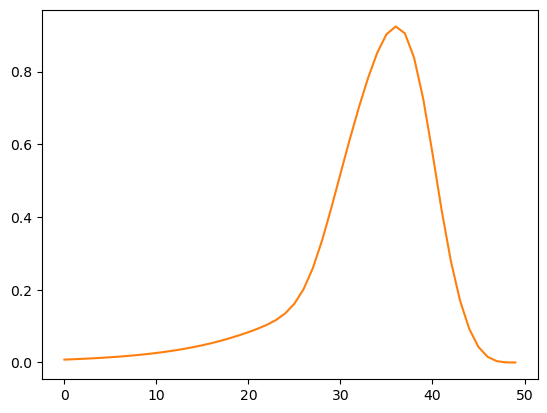

In [105]:
plt.plot(jnp.einsum("i,ijk->jk", get_params(opt_state), INPUT_GRID)[5, :])
plt.plot(INPUT_GRID[0, 5,:])

In [257]:
convolution.FK_FLAVOURS

array(['photon', '\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'V24', 'V35',
       'T3', 'T8', 'T15', 'T24', 'T35'], dtype='<U6')

In [216]:
len(chi2_contribs)

73

In [217]:
loss(get_params(opt_state), chi2_contribs)

Array(nan, dtype=float32)

In [ ]:
loss()

In [180]:
ii = iter(batch_stream())

In [16]:


cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

central_value = jnp.array(cd.central_values)

covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)



sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

jnp.sum(jla.solve_triangular(sqrt_covmat, central_value, lower=True)**2)





No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(43581.004, dtype=float32)

In [191]:
next(ii)

[<PjitFunction of <function make_chi2.<locals>.chi2 at 0x7fa188021940>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badeea160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d2d025a60>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9e01c2b790>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade95160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade67ca0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badee85e0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badef3040>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d23cdb700>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badec5ee0>>]

In [101]:
covmats.systematics_matrix_from_commondata??

In [56]:
a = np.random.rand(len(covmat))

In [67]:
import scipy.linalg as la

In [68]:
a@la.inv(covmat)@a

76949.52986563856

In [98]:
jnp.sum(jla.solve_triangular(sqrt_covmat, a, lower=True)**2)

Array(76949.53, dtype=float32)

In [69]:
from validphys.calcutils import calc_chi2

In [70]:
calc_chi2(la.cholesky(covmat, lower=True), a)

76949.52986563857

In [74]:
calc_chi2(covmats.sqrt_covmat(covmat), a)

76949.52986563857

In [76]:
sm = covmats.systematics_matrix_from_commondata(cd, ds)

In [77]:
sm.shape

(121, 226)

In [80]:
q,r = la.qr(sm)

In [81]:
q

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [86]:
la.solve_triangular(r, a)

ValueError: expected square matrix

In [88]:
import matplotlib.pyplot as plt

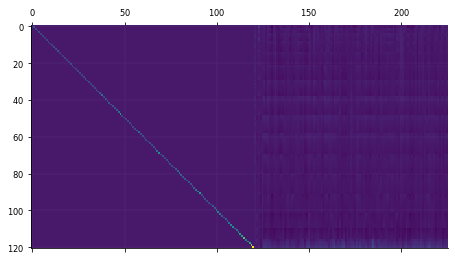

In [90]:
plt.matshow(q@r)

In [66]:
la.cholesky??

In [ ]:
from val

In [48]:
covmat

array([[ 2.68593312e-04,  1.83984561e-04,  7.67906773e-05, ...,
        -7.63211469e-05, -1.05104702e-04, -1.37744623e-04],
       [ 1.83984561e-04,  4.04746250e-04,  6.08510678e-05, ...,
        -1.27447854e-04, -1.71832192e-04, -2.22663390e-04],
       [ 7.67906773e-05,  6.08510678e-05,  1.91100734e-04, ...,
         1.14004879e-04,  1.45105124e-04,  1.87405121e-04],
       ...,
       [-7.63211469e-05, -1.27447854e-04,  1.14004879e-04, ...,
         2.33261176e-03,  1.15595913e-03,  1.43098653e-03],
       [-1.05104702e-04, -1.71832192e-04,  1.45105124e-04, ...,
         1.15595913e-03,  4.07094629e-03,  1.80012082e-03],
       [-1.37744623e-04, -2.22663390e-04,  1.87405121e-04, ...,
         1.43098653e-03,  1.80012082e-03,  6.43026459e-03]])

In [42]:
covmat_from_systematics??

In [23]:
cd.central_values

entry
46     0.9734
47     0.9821
59     0.9716
60     0.9817
61     0.9942
        ...  
256    0.6717
257    0.7194
258    0.6959
259    0.7020
260    0.7724
Name: data, Length: 121, dtype: float64

LHAPDF 6.4.0 loading /home/zah/anaconda3/envs/nnpdfdev/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1


In [318]:
pdf_base.shape

(14, 50)

In [319]:
vals.shape

(14, 50)

In [320]:
loss(vals, chi2_contribs)

Array(5888.8696, dtype=float32)

In [157]:
def loss(nn):
    return nn - vals

In [158]:
vals.shape

(1, 14, 50)

In [159]:
tb = load_fktable(ds.fkspecs[0])

In [160]:
tb.luminosity_mapping

array([ 1,  1,  1,  2,  1,  3,  1,  4,  1,  5,  1,  6,  1,  9,  1, 10,  1,
       11,  2,  2,  2,  3,  2,  4,  2,  5,  2,  6,  2,  9,  2, 10,  2, 11,
        3,  3,  3,  4,  3,  5,  3,  6,  3,  9,  3, 10,  3, 11,  4,  4,  4,
        5,  4,  6,  4,  9,  4, 10,  4, 11,  5,  5,  5,  6,  5,  9,  5, 10,
        5, 11,  6,  6,  6,  9,  6, 10,  6, 11,  9,  9,  9, 10,  9, 11, 10,
       10, 10, 11, 11, 11])

In [162]:
tb.get_np_fktable().shape

(17, 45, 50, 50)

In [163]:
from jax.example_libraries import stax

In [183]:
init, predict = stax.serial(stax.Dense((2)), stax.Dense((3)))

In [184]:
from jax import random

In [185]:
rng = random.PRNGKey(3)

In [188]:
init(rng, (1,))

((3,),
 [(Array([[-0.99891424,  0.79900575]], dtype=float32),
   Array([0.01032689, 0.01061993], dtype=float32)),
  (Array([[-0.97583795, -0.5411103 , -0.47663605],
          [-1.1263915 , -0.7123102 , -1.2609658 ]], dtype=float32),
   Array([-0.0023886 , -0.00962158,  0.01378133], dtype=float32))])

In [189]:
import numpy as np

In [192]:
initial = np.random.rand(50)

In [193]:
import matplotlib.pyplot as plt

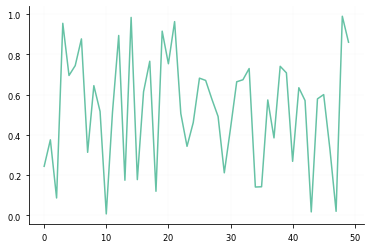

In [194]:
plt.plot(initial)

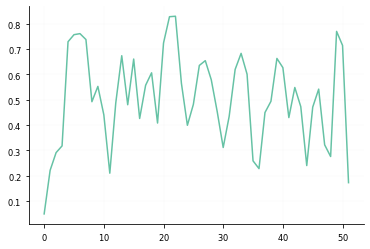

In [197]:
plt.plot(np.convolve(initial, [0.2, 0.6, 0.2]))

In [370]:
from jax.example_libraries import stax

In [373]:
pdf_base.shape

(14, 50)

In [379]:
init, apply = stax.Conv(1, (1,10))

In [380]:
stax.Conv??

In [382]:
init??

In [384]:
init(rng, (14,50,1))

IndexError: tuple index out of range

In [385]:
%debug

> /home/zah/anaconda3/envs/nnpdfdev/lib/python3.9/site-packages/jax/example_libraries/stax.py(76)<listcomp>()
     74     filter_shape_iter = iter(filter_shape)
     75     kernel_shape = [out_chan if c == 'O' else
---> 76                     input_shape[lhs_spec.index('C')] if c == 'I' else
     77                     next(filter_shape_iter) for c in rhs_spec]
     78     output_shape = lax.conv_general_shape_tuple(

ipdb> lhs_spec
'NHWC'
ipdb> q


In [393]:
@jax.jit
def f(obj):
    return obj["inte"]

In [394]:
class X:
    inte = 1

In [395]:
f({"inte":1})

Array(1, dtype=int32, weak_type=True)